# Pixel classification

This course is mostly dedicated to Neural Networks. However classical image processing as well as classical Machine Learning approaches are still widely used. In this chapter we explore how pixel classification can be used for image segmentation. The idea here is to create very sparse annotations and to then use these annotations to train a classifier.

In [1]:
# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

In [2]:
import skimage
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

First we load an image from a microscopy dataset that shows cell nuclei as bright objects over a dark background:

In [3]:
image = skimage.io.imread(datapath.joinpath('data/nuclei/BBBC006_v1_images_z_16/mcf-z-stacks-03212011_a01_s1_w1248254b0-0193-4e11-8762-62b5d2b86216.tif'))
                          

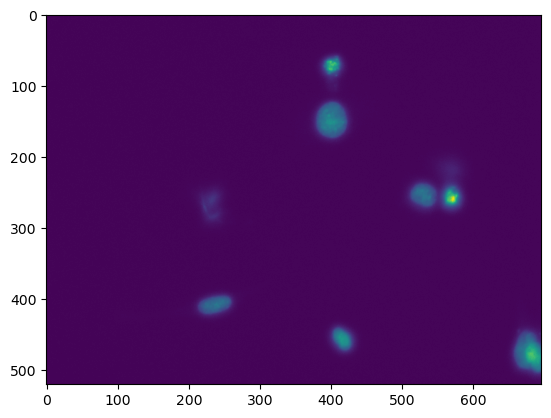

In [4]:
plt.imshow(image);

## Annotations with napari

Then we want to add some annotations. We use here this opportunity to briefly introduce an interactive visualization package called napari that we can use for this task.

In [5]:
import napari
from napari.utils import nbscreenshot

Here we first create a visualization window and then add the image as well as an empty label layer:

In [47]:
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(np.zeros(image.shape, dtype=np.uint8));

When the ```Labels``` layer is selected on the left, we get classical annotation tools. We can use the paint brush to draw on top of the image and adjust the label index. Here we need two classes, one for background and one for foreground. If you don't have access to napari (e.g. on Colab), you can use a pre-annotated image here:

In [48]:
annot = skimage.io.imread('https://github.com/guiwitz/MLCV/raw/main/supp_data/sparse_annotation.tiff')
viewer.layers['Labels'].data = annot

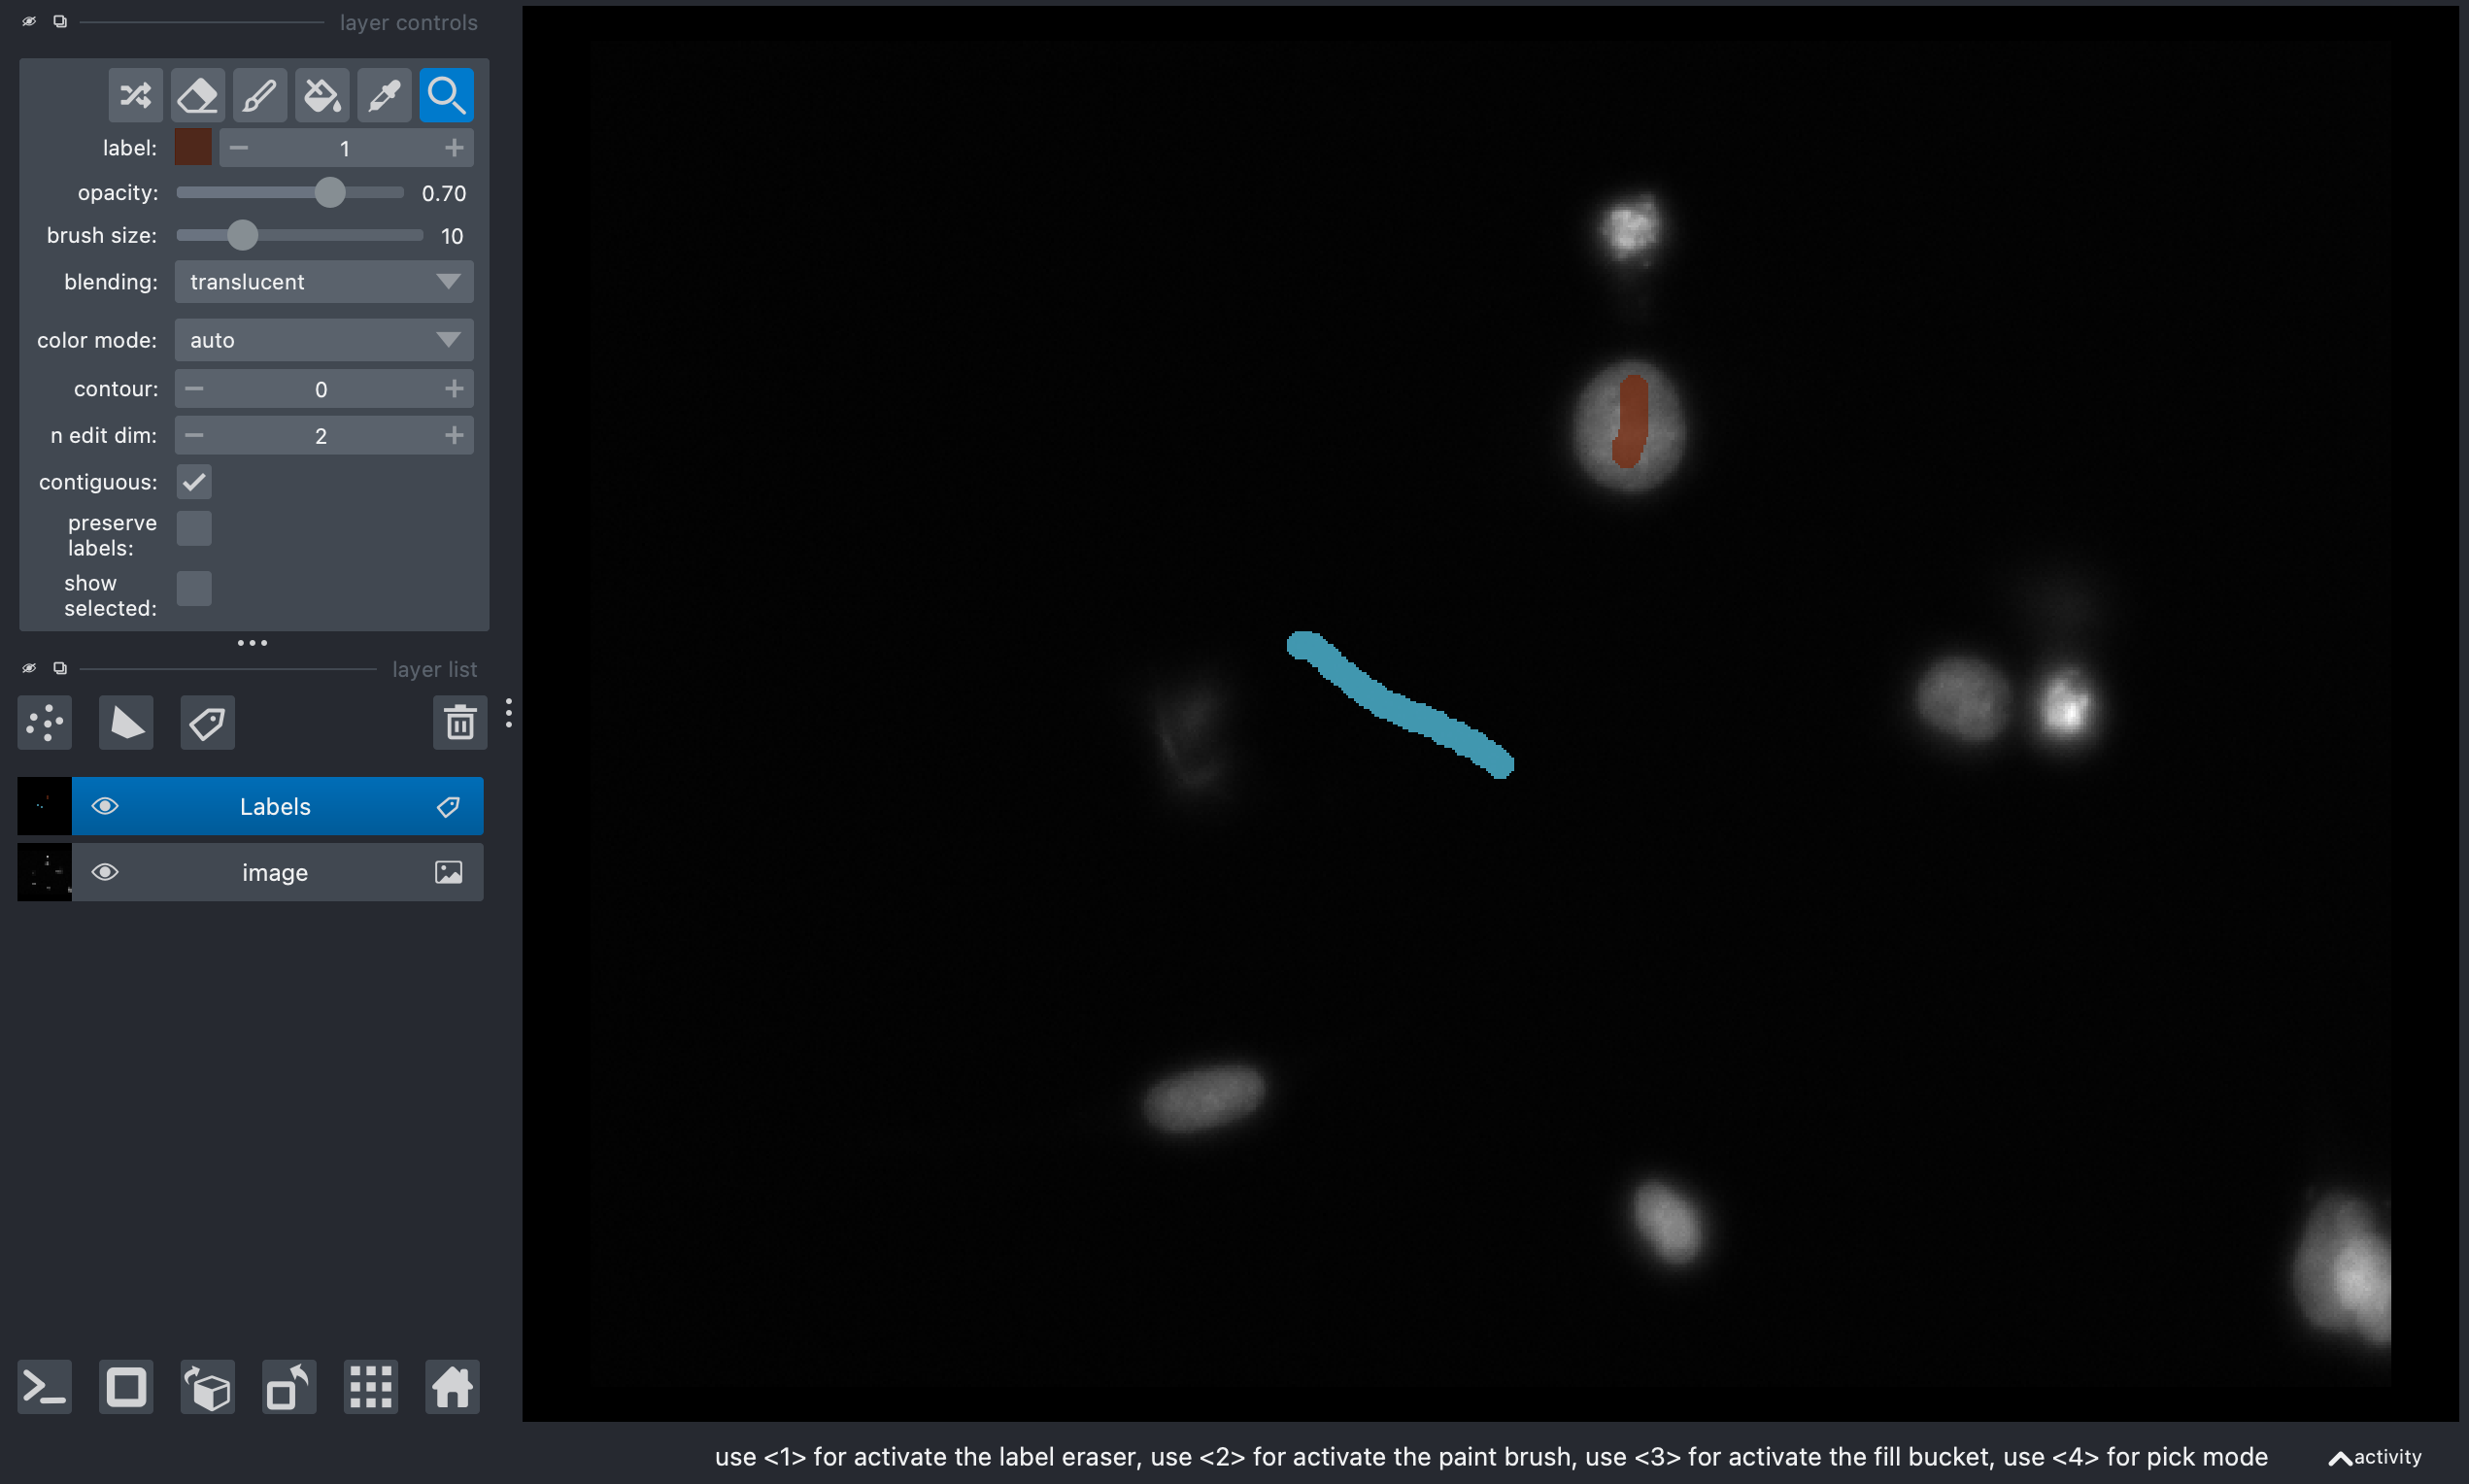

In [8]:
nbscreenshot(viewer)

## Features

Our goal is to use these annotations to train a classifier. In other words we know now for a set of pixels to which category they should belong, and want to classify all the other pixel by "similarity". At the moment, the only information we have is the pixel intensity for each annotated pixel. While in this specific example, the intensity might be sufficient to segment objects, in many cases this is not sufficient and we need more information of object size, texture, edges etc. In order to create that information, we now filter the image with a set of manually chosen filters. Each of them will highlight a different aspect of the objects.

Here we use scikit-image filters for this and at the end we collect all filtered images into one large image stack ```filtered_stack```:

In [9]:
im_gauss = skimage.filters.gaussian(image,sigma = 10, preserve_range = True)
im_gauss2 = skimage.filters.gaussian(image,sigma = 20, preserve_range = True)
im_frangi = skimage.filters.frangi(image)
im_prewitt = skimage.filters.prewitt(image)
im_meijering = skimage.filters.meijering(image)
im_gauss_laplace = skimage.filters.laplace(skimage.filters.gaussian(image,sigma = 5,preserve_range=True),ksize=10)
im_gradient = skimage.filters.rank.gradient(image,skimage.morphology.disk(8))
im_entropy = skimage.filters.rank.entropy(image,skimage.morphology.disk(8))
im_roberts = skimage.filters.roberts(skimage.filters.gaussian(image,sigma = 5,preserve_range=True))

filtered_stack = np.stack([im_gauss,im_gauss2,im_frangi,im_prewitt,im_meijering,im_gauss_laplace,im_gradient,im_entropy,im_roberts], axis=0)
names = ['Gauss $\sigma$=10', 'Gauss $\sigma$=20','Frangi','Prewitt','Meijering','Gauss+Laplace', 'Gradient',
        'Entropy','Roberts']

/Users/gw18g940/mambaforge/envs/CASImaging2023/lib/python3.9/site-packages/skimage/filters/rank/generic.py:262: UserWarning: Bad rank filter performance is expected due to a large number of bins (1474), equivalent to an approximate bitdepth of 10.5.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


As can be seen below, each of these filters captures a different aspect of the images:

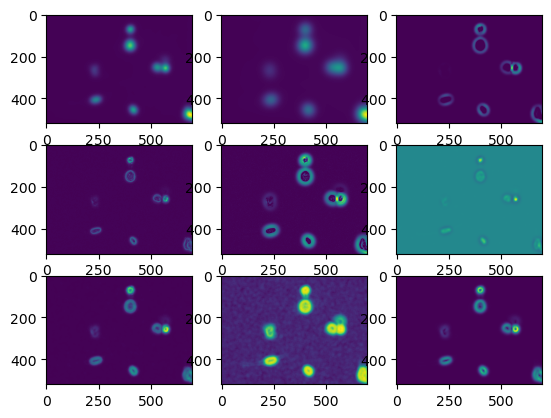

In [10]:
fig, axes = plt.subplots(3,3)
for ind, ax in enumerate(axes.ravel()):
    ax.imshow(filtered_stack[ind])

Now instead of only having the intensity information for each annotated pixel, we get 9 values, each coming from one of the filtered images. In other words, we have now for each pixel 9 features that we can use for training. Let's try to recover these features and put them in a dataframe. First we recover the labels:

In [11]:
annot = viewer.layers['Labels'].data

Our goal now is to recover in each filtered image the values of the annotated pixels in the label image. For the first image in the ```filtered_stack``` array this would be: 

In [12]:
filtered_stack[0][annot > 0].shape

(1484,)

We see that we have 1484 annotated pixels. We could write a for loop and do this extraction of pixel values for each frame in our filtered stack. More elegantly, we can replicate the annotation image 9 times and use indexing in one go:

In [13]:
filtered_stack.shape

(9, 520, 696)

In [14]:
annot.shape

(520, 696)

In [15]:
annot_stack = annot[np.newaxis,:,:].repeat(9, axis=0)
annot_stack.shape

(9, 520, 696)

In [72]:
filtered_stack[annot_stack > 0].shape

(13356,)

In [76]:
features = filtered_stack[annot_stack > 0]
# reshape to have a table of N pixels by m features
features = features.reshape(9, -1).T

Now that we have the necessary features, we also need labels. These are just the annotations themselves:

In [78]:
targets = np.ravel(annot[annot>0]).astype(int)

In [79]:
targets

array([1, 1, 1, ..., 2, 2, 2])

## Classififer

Now that we have our tables (arrays) of N pixels by M features and N labels, we can use them with scikit-learn to train a classical classfiier. Here we use a Random Forest Classifier because of its simplicity, but other classifier could work.

We initialize it and then train it (```fit```) using the ```features``` and ```targets``` as inputs:

In [83]:
from sklearn.ensemble import RandomForestClassifier

random_forrest = RandomForestClassifier(n_estimators=1000)
random_forrest.fit(X=features, y=targets)

RandomForestClassifier(n_estimators=1000)

## Inference

Now our classifier is trained, and so we can give it any 9-tuple values of a pixel and it will tell us if that pixel is foreground or background! Let's extract this time the features of **all** pixels. First we flatten the pixel dimensions of the filtered array so that each pixels with its 9 features is a data point:

In [84]:
all_pixels = np.reshape(filtered_stack, (9, filtered_stack.shape[1]*filtered_stack.shape[2])).T

In [85]:
all_pixels.shape

(361920, 9)

Now we can feed this to our model and reshape the output into an image:

In [86]:
predictions = random_forrest.predict(all_pixels)

predicted_image = np.reshape(predictions, image.shape)

In [87]:
viewer.add_labels(predicted_image.astype(np.uint8), name='prediction');

## Saving the model

Now we can save the model. There are different ways of doing this. Here we use the recommended way using the ```joblib``` package:

In [112]:
from joblib import dump, load
dump(random_forrest, datapath.joinpath('models/pix_classifier.joblib'))

['../models/pix_classifier.joblib']

When needed we can reload the model using ```mymodel = load('filename.joblib')```

## Exercise

Try to run the trained model on the image that you can find at https://github.com/guiwitz/MLCV/raw/main/supp_data/CIL_32146_c1.tiff (originally from http://www.cellimagelibrary.org/images/32146)
